## Data Preprocessing

In [1]:
# Importing the necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

/Users/nevrocerasani/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
# Importing the dataset and adjusting it according to our needs

df = pd.read_csv("FootballDataEurope.csv")
df = df.iloc[:, [1,2,3,5,6,7,8,9]]
df.columns = ["Country", "League", "Season", "Date", "Home Team", "Away Team", "Home Team Goals", "Away Team Goals"]
df.sort_values(["Country", "Date"], inplace=True)

In [3]:
# Changing the format of dates in order to work more comfortable with them

def date(dates):
    dates = dates.replace("/", "-")
    return dates
df["Season"] = df["Season"].apply(lambda x: date(x))

In [4]:
# Giving a look to the dataset in its final shape

df.head()

,Country,League,Season,Date,Home Team,Away Team,Home Team Goals,Away Team Goals
52,Belgium,Belgium Jupiler League,2008-2009,2008-08-16 00:00:00,SV Zulte-Waregem,Sporting Lokeren,0,0
53,Belgium,Belgium Jupiler League,2008-2009,2008-08-16 00:00:00,KSV Cercle Brugge,RSC Anderlecht,0,3
54,Belgium,Belgium Jupiler League,2008-2009,2008-08-16 00:00:00,FCV Dender EH,Standard de Liège,1,3
55,Belgium,Belgium Jupiler League,2008-2009,2008-08-16 00:00:00,KSV Roeselare,KV Kortrijk,2,2
56,Belgium,Belgium Jupiler League,2008-2009,2008-08-16 00:00:00,Tubize,Royal Excel Mouscron,1,2


In [5]:
# Creating a list of all the leagues and the seasons concatenated

leagues = df.League.unique()
seasons = df.Season.unique()
league_season = []
for i in leagues:
    for j in seasons:
        ls = []
        ls.append(i)
        ls.append(j)
        league_season.append(ls)

In [6]:
# Separating the dataset in order to have a .csv file for each season in each league.
# I commented this code because it needs to be executed only once.
# NOTE: make sure to create a folder named "Leagues Seasons" in your working directory otherwise it will not work
# (this little issue could be solved by using some functions from the OS package).

#for i in league_season:
    #df[(df["League"]==i[0]) & (df["Season"]==i[1])].to_csv("Leagues Seasons/" + str(i[0]) + " " + str(i[1]) + ".csv")

In [7]:
# Defining a function to create the features we will need for our predictions.

def stats(season):
    season = season.drop("Unnamed: 0", axis=1)
    teams = season["Home Team"].unique()
    window = 5
    nan_col = np.nan
    season["HAS"] = nan_col
    season["HDS"] = nan_col
    season["AAS"] = nan_col
    season["ADS"] = nan_col
    season["OH"] = nan_col
    season["OA"] = nan_col
    season["Over/Under"] = [1 if (j["Home Team Goals"] + j["Away Team Goals"])>2 else 0 for i,j in season.iterrows()]
    for i in teams:
        hometeam = season["Home Team"]==i
        awayteam = season["Away Team"]==i
        season["HAS"][hometeam] = season["Home Team Goals"][hometeam].ewm(span=window).mean()
        season["HDS"][hometeam] = season["Away Team Goals"][hometeam].ewm(span=window).mean()
        season["AAS"][awayteam] = season["Away Team Goals"][awayteam].ewm(span=window).mean()
        season["ADS"][awayteam] = season["Home Team Goals"][awayteam].ewm(span=window).mean()
        season["OH"][hometeam] = season["Over/Under"][hometeam].ewm(span=window).mean()
        season["OA"][awayteam] = season["Over/Under"][awayteam].ewm(span=window).mean()
    season = season.dropna()
    return season

In [8]:
# Applying the previous function to all the datasets previously exported and eventually merging them to recreate
# one large dataset.

concat_list = []
for i in league_season:
    concat_list.append("Leagues Seasons/" + str(i[0]) + " " + str(i[1]) + ".csv")
df_merge = []
for i in concat_list:
    try:
        df_tomerge = pd.read_csv(i) 
        df_merge.append(stats(df_tomerge))
    except:
        continue
merged_df = pd.concat(df_merge)

/Users/nevrocerasani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nevrocerasani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nevrocerasani/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/nevrocerasani/opt/anaconda3/lib/p

In [9]:
# Giving a look to the final dataset we are going to use for our predictions

merged_df.tail()

,Country,League,Season,Date,Home Team,Away Team,Home Team Goals,Away Team Goals,HAS,HDS,AAS,ADS,OH,OA,Over/Under
175,Switzerland,Switzerland Super League,2015-2016,2016-05-25 00:00:00,FC Basel,Grasshopper Club Zürich,0,1,1.349294,0.937589,0.772233,1.151697,0.395948,0.356397,0
176,Switzerland,Switzerland Super League,2015-2016,2016-05-25 00:00:00,Lugano,FC St. Gallen,3,0,1.585333,1.418041,0.670711,2.592723,0.724248,0.813158,1
177,Switzerland,Switzerland Super League,2015-2016,2016-05-25 00:00:00,FC Luzern,FC Sion,2,2,2.767976,1.007609,1.401426,1.696838,0.968361,0.595714,1
178,Switzerland,Switzerland Super League,2015-2016,2016-05-25 00:00:00,FC Thun,BSC Young Boys,0,3,1.231006,1.798619,2.355924,0.952189,0.710234,0.908765,1
179,Switzerland,Switzerland Super League,2015-2016,2016-05-25 00:00:00,FC Zürich,FC Vaduz,3,1,1.628038,1.903931,1.838284,2.342107,0.760587,0.955183,1


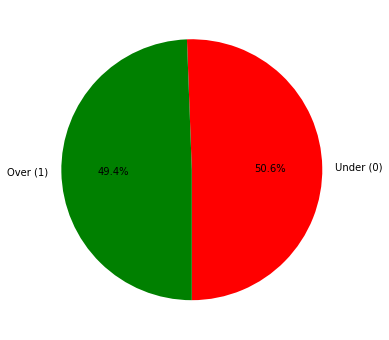

In [10]:
# Checking if there's balance among the number of under and over

labels = ["Under (0)", "Over (1)"]
under_len = len(merged_df[merged_df["Over/Under"]==0])
over_len = len(merged_df[merged_df["Over/Under"]==1])
sizes = [over_len, under_len]
colors = ["red", "green"]
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=270)
plt.show()

## Predictions

In [11]:
# Splitting the data into training and testing

X = merged_df[["HAS", "HDS", "AAS", "ADS", "OH", "OA"]]
y = merged_df["Over/Under"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Trying to predict Over/Under using Logistic Regression

log_reg = LogisticRegression(solver="liblinear", penalty="l2", C=0.1)
log_reg.fit(X_train, y_train)
test_log_reg = log_reg.predict(X_test)

In [13]:
# Checking the accuracy of the Logistic Regression algorithm

metrics.accuracy_score(y_test, test_log_reg)*100

94.58557865024378

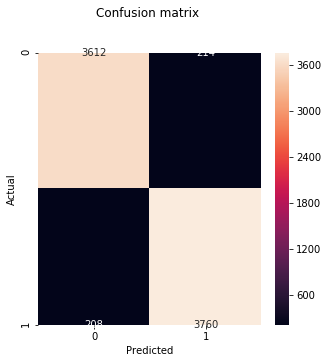

In [14]:
cm = metrics.confusion_matrix(y_test, test_log_reg)
plt.figure(figsize=(5,5))
sn.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix \n \n")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [15]:
# Trying to predict Over/Under using a Deep Neural Network
# NOTE: Commented because the neural network needs to be fitted and saved only once (and then re-loaded),
# in order to preserve the same model and save computational power. 

#model = Sequential()
#model.add(Dense(100, input_dim=6, activation = "relu"))
#model.add(Dropout(0.5))
#model.add(Dense(100, activation = "relu"))
#model.add(Dropout(0.5))
#model.add(Dense(100, activation = "relu"))
#model.add(Dropout(0.5))
#model.add(Dense(100, activation = "relu"))
#model.add(Dense(100, activation = "relu"))
#model.add(Dense(1, activation="sigmoid"))
#model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

#model.fit(X_train, y_train, batch_size = 512, epochs=1000)

In [16]:
#model.save('over_under.h5')
model = load_model('over_under.h5')

In [17]:
# Checking the accuracy of the model

model.evaluate(X_test, y_test)

7794/7794 [==============================] - 0s 29us/step


[0.10643519260216774, 0.9507313370704651]

## Analysis of the errors

In this final section we analyse the the errors to check whether they have something in common, and then, based on the results, we will try to elaborate a betting strategy.  
We can interpret the outcome of the logistic regression as the "final" prediction, and the outcome of the neural network as the probability of that prediction corresponding to the actual outcome.  
For our analysis, we are going to divide the probabilities resulting from the model in 10 classes from 0 to 1 in steps of 0.1, and assume for a moment that our betting strategy would be to bet under when the probability is less than 0.5, and to bet over when the probability is greater or equal to 0.5.

In [18]:
predictions = X_test.copy()
predictions["Prediction"] = log_reg.predict(X_test)
predictions["Actual"] = y_test
predictions["Probability"] = np.round(model.predict(X_test), 2)

In [19]:
predictions.tail()

,HAS,HDS,AAS,ADS,OH,OA,Prediction,Actual,Probability
53,1.736842,0.947368,2.315789,0.473684,0.684211,0.789474,1,1,1.00
192,1.556017,0.498712,0.723826,0.873193,0.199430,0.208669,0,0,0.00
36,1.600000,0.400000,1.200000,2.800000,0.000000,0.400000,0,0,0.00
237,1.554731,0.844972,1.266293,1.450116,0.448717,0.605091,1,1,0.66
148,1.400591,1.405591,1.340262,1.152496,0.456665,0.522091,0,0,0.62


In [20]:
step = 0.1
classes_over = np.arange(0.5, 1, step=step)
counter_over = []
for i in classes_over:
    counter_list = []
    for j in predictions["Probability"]:
        if i<=j<=i+step:
            counter_list.append(j)
    num = len(predictions[(predictions["Probability"]>i) & (predictions["Actual"]==1) & (predictions["Prediction"]==0)])
    counter_over.append(np.round(num/len(counter_list),4)*100)

In [21]:
classes_under = np.arange(0, 0.5, step=step)
counter_under = []
for i in classes_under:
    counter_list = []
    for j in predictions["Probability"]:
        if i<=j<=i+step:
            counter_list.append(j)
    num = len(predictions[(predictions["Probability"]<i) & (predictions["Actual"]==0) & (predictions["Prediction"]==1)])
    counter_under.append(np.round(num/len(counter_list),4)*100)

In [22]:
classes = [[round(i,1), round(i+step,1)] for i in np.arange(0, 1, step=step)]
errors = pd.DataFrame()
errors["Classes"] = classes
errors["% Error Under"] = np.NaN
errors["% Error Over"] = np.NaN
errors.iloc[0:5, 1] = counter_under
errors.iloc[5:, 2] = counter_over
errors.set_index("Classes", inplace=True)

In [23]:
errors

,% Error Under,% Error Over
Classes,,
"[0.0, 0.1]",0.00,NaN
"[0.1, 0.2]",1.12,NaN
"[0.2, 0.3]",6.20,NaN
"[0.3, 0.4]",48.60,NaN
"[0.4, 0.5]",61.48,NaN
"[0.5, 0.6]",NaN,63.37
"[0.6, 0.7]",NaN,12.70
"[0.7, 0.8]",NaN,1.89
"[0.8, 0.9]",NaN,1.40


How to interpret these results:  
- Every time the probability was between 0 and 0.1, the model always correctly predicted the outcome (Under);
- Every time the probability was between 0.1 and 0.2, the model made mistakes 1.12% of the times;
- Every time the probability was between 0.8 and 0.9, the model made mistakes 1.40% of the times.

And so on.  
  
We can conclude that, relying on this model, a good betting strategy would be to bet:  
- Under when the probability is between 0 and 0.3;
- Over when the probability is between 0.7 and 1.